In [27]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import math 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder

In [28]:
df_attributes=pd.read_csv("datasets/RunningShoes_Challenge/data/runner_attributes.csv")
df_time=pd.read_csv("datasets/RunningShoes_Challenge/data/marathon_times.csv")
#checked for dimension, checked what we see in duplicates

[20 30 35 45 40 50 55 15 60 65 70 75 80]
(92,) ['KEN' 'ETH' 'AUS' 'BRA' 'KOR' 'JPN' 'GBR' 'USA' 'ITA' 'ISR' 'FRA' 'EST'
 'DEU' 'CHE' 'ZAF' 'FIN' 'NOR' 'DNK' 'ESP' 'BEL' 'HUN' 'SWE' 'NLD' 'AUT'
 'EGY' 'RUS' 'CAN' 'POL' 'ISL' 'MLT' 'IRL' 'GAN' 'VEN' 'PRT' 'MEX' 'SVN'
 'AGO' 'CHL' 'LUX' 'DZA' 'LIE' 'CZE' 'CRI' 'TUR' 'KZK' 'IND' 'NZL' 'HRV'
 'ECU' 'BGR' 'GRC' 'CUB' 'PER' 'SLV' 'YUG' 'NIC' 'COL' 'MAR' 'MKO' 'COM'
 'IRN' 'PRI' 'SGP' 'DOM' 'BOL' 'LBR' 'SEN' 'ARG' 'GHA' 'LBN' 'BIH' 'LVA'
 'ALB' 'LTU' 'ISI' 'PAK' 'AFG' 'MUS' 'SVK' 'CHN' 'TWN' 'MLI' 'CYP' 'AHO'
 'ROU' 'IDN' 'BLR' 'FLK' 'THA' 'SDN' 'NGA' 'PHL']
test shapes (30373, 4) (30373,)


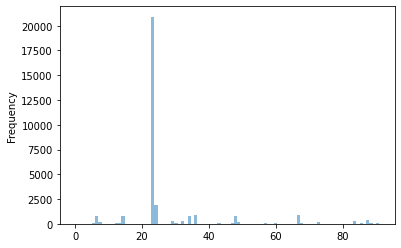

In [46]:
df_merged=df_attributes.join(df_time, lsuffix='_attr', rsuffix='_tim')
#df_merged=df_merged.drop([df_merged.columns[0]], axis='columns')
df_merged.to_csv('df_test.csv')
#print(df_merged.head())
df_merged['unique_id'] = np.where((df_merged['unique_id_attr'] == df_merged['unique_id_tim'])
                     , df_merged['unique_id_attr'], np.NaN)
df_merged.to_csv('df_merged_attributes_time_nodrop.csv')
#do opposite selection JUST to be sure
df_merged['unique_id'] = np.where((df_merged['unique_id_attr'] == df_merged['unique_id_tim'])
                     , df_merged['unique_id_attr'], np.NaN)
#drop columns for times
df_merged=df_merged.drop(columns=['unique_id_attr', 'unique_id_tim'])
df_merged=df_merged.dropna(axis=0)
df_merged.shape
df_merged.treatment.replace(['Treatment', 'Control'], [1, 0], inplace=True)
df_merged.ageClass.replace(['U20'], [15], inplace=True)
df_merged.sex.replace(['M', 'W'], [0, 1], inplace=True)
df_merged.to_csv('df_merged_after_transform.csv')
df_merged['ageClass']=df_merged['ageClass'].astype(int)
#df_merged.plot.bar()
ageClass_values=df_merged['ageClass'].unique()
print(ageClass_values)
nationalities=df_merged['nationality'].unique()
print(nationalities.shape,nationalities)
le = LabelEncoder()
df_merged['nationality']=le.fit_transform(df_merged['nationality'])
#transformed_data = nations_encoder.transform(df_variables['nationality'])
#onehotenc_df = pd.DataFrame(transformed_data)
#data_new = pd.concat([df_variables, onehotenc_df], axis=1).drop(['nationality'], axis=1)
#df_variables.to_csv('data_new.csv')
df_merged['nationality'].plot.hist(bins=92,alpha=0.5)
df_X_input=df_merged[['ageClass','sex','treatment','nationality']]
df_time_values=df_merged['netTime']
print("test shapes",df_X_input.shape,df_time_values.shape)
X, y = np.arange(10000).reshape((100, 100)), range(100)
split_value=0.25
X_train, X_test, y_train, y_test = train_test_split(df_X_input, df_time_values, test_size=split_value)

Use now scatter plot to find some correlations:

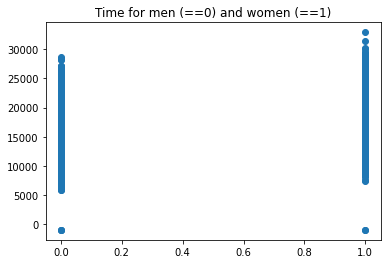

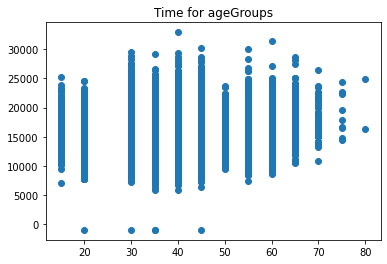

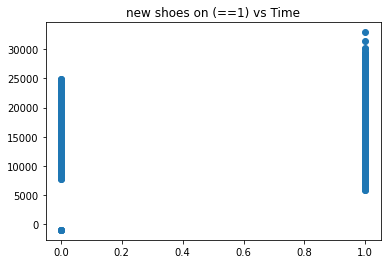

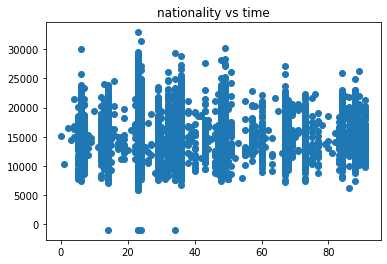

In [40]:
plt.scatter(df_merged["sex"],df_merged["netTime"])
plt.title("Time for men (==0) and women (==1)")
plt.show()
plt.scatter(df_merged["ageClass"],df_merged["netTime"])
plt.title("Time for ageGroups")
plt.show()
plt.scatter(df_merged["treatment"],df_merged["netTime"])
plt.title("new shoes on (==1) vs Time")
plt.show()
plt.scatter(df_orig["nationality"],df_merged["netTime"])
plt.title("nationality vs time")
plt.show()

We already found out the new shoes (treatment) did have the participants with longest times in. On average men are faster than women, for age groups above 50 times rise quite a bit, we also see larger statistics in age groups around 40 before, so tails can also be larger there. For nationalities

rms train,test 2677.356175348673 2679.838121263667


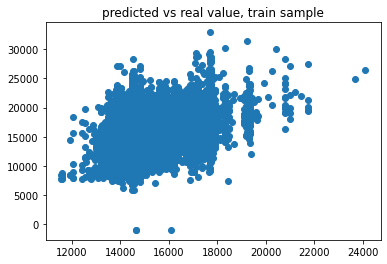

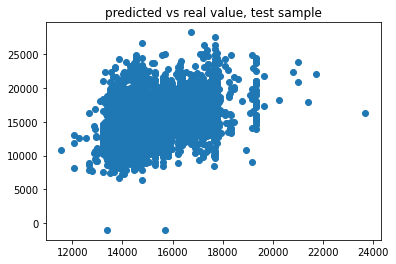

In [57]:
XGB_Model_sklearn =xgb.XGBRegressor()
param_default = {'seed': 7,'base_score': 0.5,'subsample':1,'max_delta_step':0,'max_depth': 4, 'eta': 0.01, 'objective': 'reg:squarederror','nthread':4,'eval_set': [X_test,y_test], 'early_stopping_round': 10,
               'gamma': 0.0, 'min_child_weight': 1.0,'lambda': 1, 'alpha': 0,'tree_method':'exact','subsample':1,
                'colsample_bytree': 1,'colsample_bylevel':1,'colsample_bynote': 1}
XGB_Model_sklearn.set_params(**param_default)
XGB_Model_sklearn.fit(X_train,y_train)
pred_value_train=XGB_Model_sklearn.predict(X_train)
pred_value_test=XGB_Model_sklearn.predict(X_test)
rms_train=np.sqrt(mean_squared_error(pred_value_train, y_train))
rms_test=np.sqrt(mean_squared_error(pred_value_test, y_test))
#at least not any overtraining
print("rms train,test",rms_train,rms_test)
plt.scatter(pred_value_train,y_train)
plt.title("predicted vs real value, train sample")
plt.show()
plt.scatter(pred_value_test,y_test)
plt.title("predicted vs real value, test sample")
plt.show()

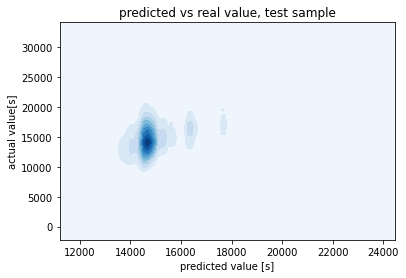

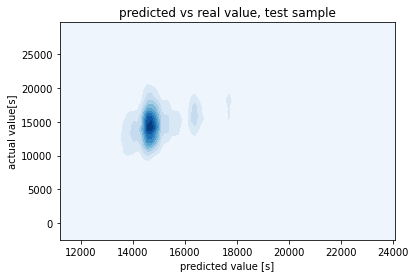

<Figure size 432x288 with 0 Axes>

In [58]:
import seaborn as sns

sbn_fig=sns.kdeplot(pred_value_train, y_train, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("predicted vs real value, test sample")
plt.xlabel('predicted value [s]')
plt.ylabel('actual value[s]')
plt.show()
plt.savefig("pred_vs_actualValue_Train.eps")
sbn_fig=sns.kdeplot(pred_value_test, y_test, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("predicted vs real value, test sample")
plt.xlabel('predicted value [s]')
plt.ylabel('actual value[s]')
plt.show()
plt.savefig("pred_vs_actualValue_Test.eps")

In [ ]:
from sklearn import linear_model
